# Importing Relevant Packages

In [ ]:
# pip install yfinance
# pip install pmdarima

In [116]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../Scripts"))
from download_data import StockData
from preprocessing import DataPreprocessor
from eda import TeslaStockAnalysis
from build_model import ARIMAForecaster, LSTMForecaster, SARIMAForecaster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Task 1: Preprocess and Explore the Data

### Load and Clean Data

In [13]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = "2020-01-01"
end_date = "2025-01-31"

# Create instance of StockData
stock_data = StockData(tickers, start_date, end_date)

In [14]:
stock_data.download_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Price           Close                               High              \
Ticker            BND         SPY        TSLA        BND         SPY   
Date                                                                   
2020-01-02  72.948776  301.194885   28.684000  73.070400  301.213446   
2020-01-03  73.209366  298.914215   29.534000  73.226745  300.054588   
2020-01-06  73.122505  300.054535   30.102667  73.244129  300.137973   
2020-01-07  73.061699  299.210876   31.270666  73.148572  299.961845   
2020-01-08  72.948776  300.805481   32.809334  73.148585  302.038544   
...               ...         ...         ...        ...         ...   
2025-01-24  71.805977  607.969971  406.579987  71.855810  610.780029   
2025-01-27  72.184738  599.369995  397.149994  72.204677  599.690002   
2025-01-28  72.144867  604.520020  398.089996  72.154837  605.369995   
2025-01-29  72.104996  601.809998  389.100006  72.254510  604.130005   
2025-01-30  72.204674  605.039978  400.279999  72.294378  606.599976   

Price                         Low                               Open  \
Ticker            TSLA        BND         SPY        TSLA        BND   
Date                                                                   
2020-01-02   28.713333  72.914026  299.025418   28.114000  72.957466   
2020-01-03   30.266666  73.061680  297.699684   29.128000  73.131182   
2020-01-06   30.104000  73.070382  297.013540   29.333332  73.235447   
2020-01-07   31.441999  73.035638  298.756566   30.224001  73.148572   
2020-01-08   33.232666  72.887964  299.155201   31.215334  73.087772   
...                ...        ...         ...         ...        ...   
2025-01-24  418.880005  71.636531  606.799988  405.779999  71.766106   
2025-01-27  406.690002  72.025262  594.640015  389.000000  72.104996   
2025-01-28  400.589996  71.975421  597.250000  386.500000  72.154837   
2025-01-29  398.589996  71.935550  599.219971  384.480011  72.194707   
2025-01-30  412.500000  72.144864  600.719971  384.410004  72.224605   

Price                                Volume                       
Ticker             SPY        TSLA      BND       SPY       TSLA  
Date                                                              
2020-01-02  299.961822   28.299999  5511000  59151200  142981500  
2020-01-03  297.755309   29.366667  5368300  77709700  266677500  
2020-01-06  297.134071   29.364668  3710400  55653900  151995000  
2020-01-07  299.479722   30.760000  3029900  40496400  268231500  
2020-01-08  299.405514   31.580000  3674400  68296000  467164500  
...                ...         ...      ...       ...        ...  
2025-01-24  609.809998  414.450012  5555700  34604700   56427100  
2025-01-27  594.809998  394.799988  8621200  70361100   58125500  
2025-01-28  600.619995  396.910004  4424300  44433300   48910700  
2025-01-29  603.719971  395.209991  5780200  37177400   68033600  
2025-01-30  603.960022  410.779999  5622300  39281300   98092900  

[1277 rows x 15 columns]

In [15]:
close_df, high_df, low_df, open_df, volume_df = stock_data.extract_price_categories()

In [16]:
close_df, high_df, low_df, open_df, volume_df = stock_data.reset_indexes()

In [17]:
close_df, high_df, low_df, open_df, volume_df = stock_data.melt_data()

### Alternatively I can run it only using this

In [18]:
# Process the data
stock_data.process_data()

[*********************100%***********************]  3 of 3 completed


In [19]:
# Get the merged DataFrame
stock_data.merge_data()
df_merged = stock_data.get_merged_data()

In [20]:
df_merged.head()

,Date,Ticker,Open,Low,Volume,High,Close
0,2020-01-02,TSLA,28.299999,28.114000,142981500,28.713333,28.684000
1,2020-01-03,TSLA,29.366667,29.128000,266677500,30.266666,29.534000
2,2020-01-06,TSLA,29.364668,29.333332,151995000,30.104000,30.102667
3,2020-01-07,TSLA,30.760000,30.224001,268231500,31.441999,31.270666
4,2020-01-08,TSLA,31.580000,31.215334,467164500,33.232666,32.809334


In [21]:
data = df_merged

In [22]:
tsla = data[data.Ticker=='TSLA']

## Preprocessing

In [23]:
# Initialize the preprocessor
preprocessor = DataPreprocessor(tsla)

### Handling Duplicates

In [24]:
# Apply data cleaning and transformation steps
preprocessor.handle_duplicates()

Removed 0 duplicate rows.


### Handle Missing Values

In [25]:
preprocessor.handle_missing_values()

Filled 0 missing values.


### Check Outlier

In [26]:
preprocessor.check_outliers()

Outlier count per column: {'Open': 80, 'Low': 77, 'Volume': 92, 'High': 81, 'Close': 83}


### Check Datatypes

In [27]:
preprocessor.check_data_types()


Data Types:
 Date      datetime64[ns]
Ticker            object
Open             float64
Low              float64
Volume             int64
High             float64
Close            float64
dtype: object


### Data Normalization

In [28]:
# Processed Data
processed_data = preprocessor.Normalized_data()
processed_data.head()

,Open,Low,Volume,High,Close,Date
0,0.007363,0.010933,0.128385,0.003732,0.010098,2020-01-02
1,0.009728,0.013269,0.268205,0.007098,0.011963,2020-01-03
2,0.009724,0.013742,0.138573,0.006745,0.013211,2020-01-06
3,0.012818,0.015794,0.269962,0.009644,0.015774,2020-01-07
4,0.014637,0.018077,0.494826,0.013524,0.019150,2020-01-08


In [29]:
processed_data.shape

(1277, 6)

In [98]:
# processed_data.index

### Exploratory Data Analysis (EDA)

In [30]:
# Sort index to ensure chronological order
df = processed_data

In [31]:
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df = df.set_index('Date')

# Sort by the new index
df = df.sort_index()


In [32]:
df.head()

,Open,Low,Volume,High,Close
Date,,,,,
2020-01-02,0.007363,0.010933,0.128385,0.003732,0.010098
2020-01-03,0.009728,0.013269,0.268205,0.007098,0.011963
2020-01-06,0.009724,0.013742,0.138573,0.006745,0.013211
2020-01-07,0.012818,0.015794,0.269962,0.009644,0.015774
2020-01-08,0.014637,0.018077,0.494826,0.013524,0.019150


In [102]:
# Initialize the analysis class
ts_analysis = TeslaStockAnalysis(df)

### Visualize Closing Prices

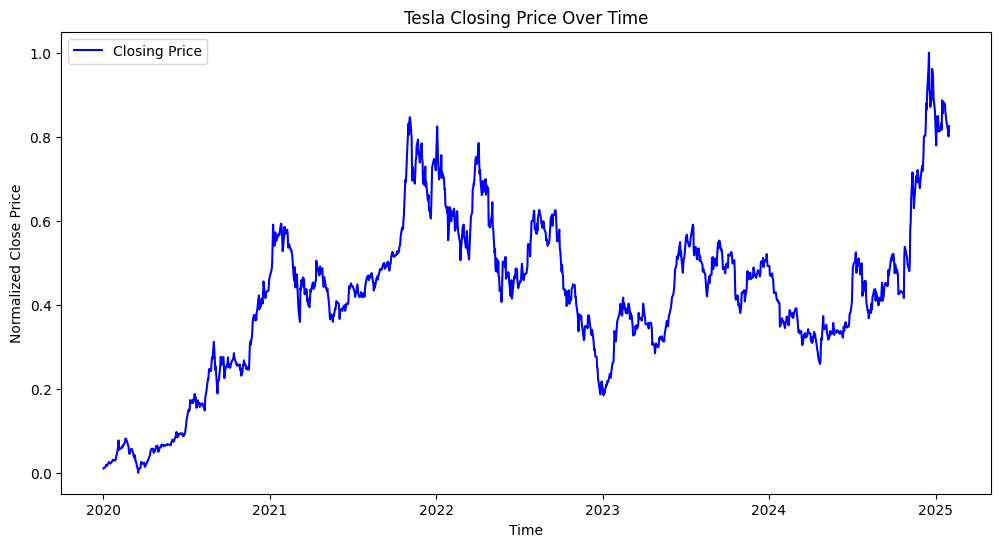

In [103]:
# Run Exploratory Data Analysis
ts_analysis.plot_closing_price()

### Calculate Daily Returns

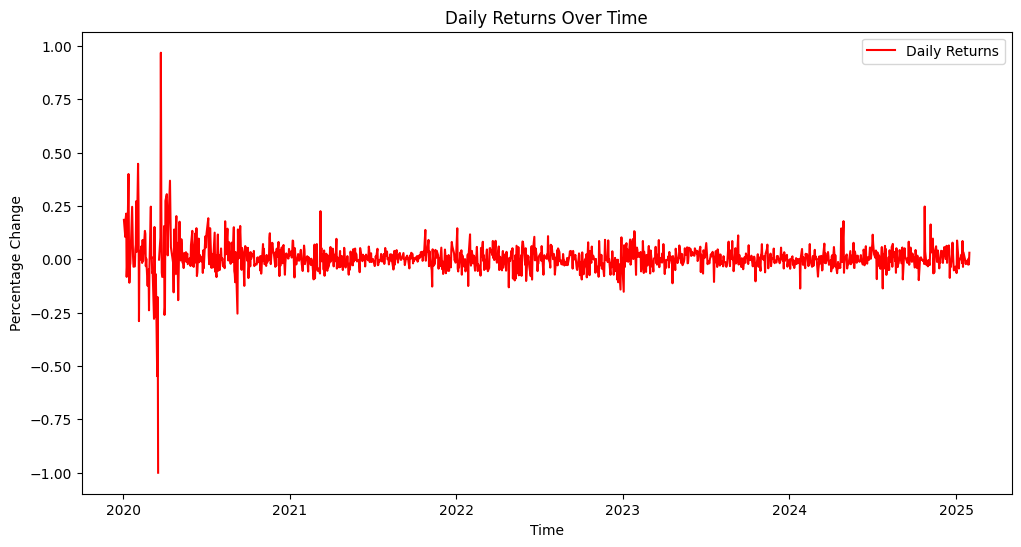

In [104]:
ts_analysis.calculate_daily_returns()

In [105]:
outliers = ts_analysis.detect_outliers()

Identified 22 outlier days with extreme returns.


In [106]:
outliers

,Date,Open,Low,Volume,High,Close,Daily Returns,Z-Score
7,2020-01-13,0.017564,0.021727,0.416379,0.017444,0.023936,0.399470,5.430545
12,2020-01-21,0.022997,0.027318,0.268629,0.020759,0.027203,0.245847,3.316523
19,2020-01-30,0.038103,0.041076,0.458565,0.035535,0.040896,0.272194,3.679089
21,2020-02-03,0.044204,0.049601,0.764766,0.055072,0.061255,0.447313,6.088923
22,2020-02-04,0.075144,0.074226,1.000000,0.081484,0.076915,0.255647,3.451390
23,2020-02-05,0.066318,0.054299,0.787805,0.063716,0.054629,-0.289746,-4.053834
38,2020-02-27,0.052530,0.048907,0.378392,0.048375,0.046482,-0.238996,-3.355459
40,2020-03-02,0.049759,0.051621,0.309177,0.048941,0.055934,0.246537,3.326017
45,2020-03-09,0.034107,0.039079,0.256255,0.037286,0.036096,-0.278969,-3.905534
48,2020-03-12,0.030484,0.030058,0.287375,0.027392,0.029156,-0.269880,-3.780461


### Decompose Tesla’s Stock Price (Trend, Seasonality, Residuals)

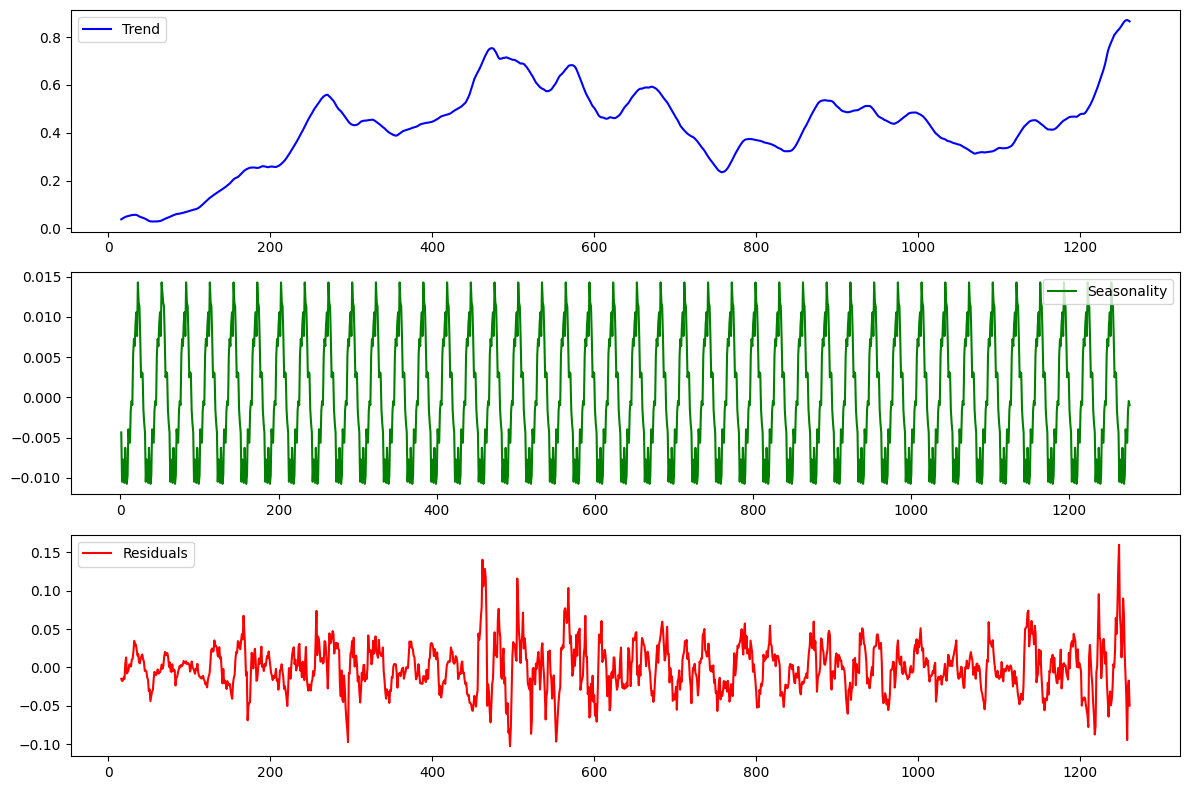

In [107]:
# Perform Trend & Seasonality Analysis
ts_analysis.decompose_time_series()

### Rolling Volatility (Standard Deviation)

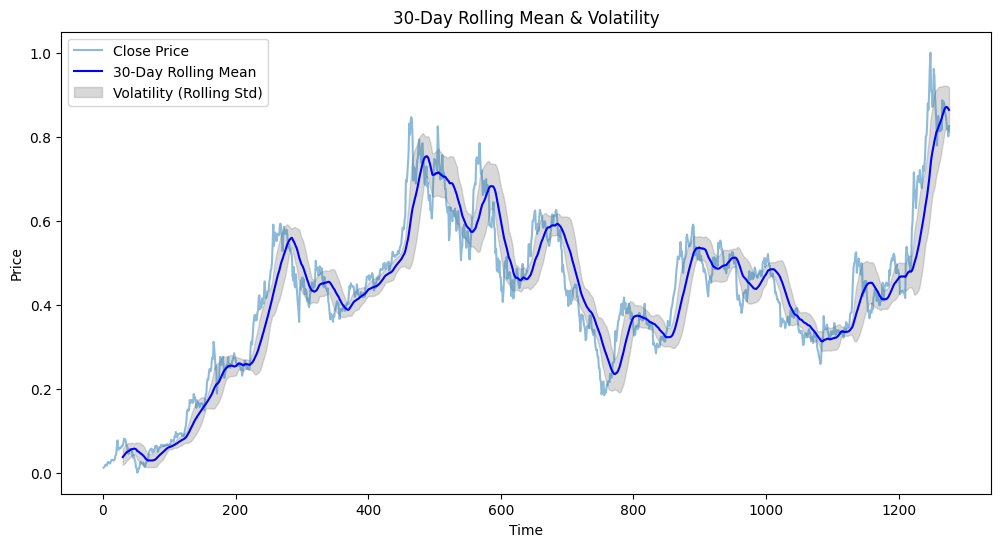

In [108]:
# Analyze Volatility & Risk
ts_analysis.rolling_volatility_analysis(window=30)

In [109]:
ts_analysis.risk_analysis()

VaR (95% confidence): -0.1151
Sharpe Ratio: 0.0666


In [ ]:
# ts_forecaster = TimeSeriesForecaster(data=tesla_stock_prices)
# ts_forecaster.train_model()
# forecast, conf_int = ts_forecaster.forecast(steps=180)
# market_forecaster = MarketForecaster(forecast)
# trend_analysis = market_forecaster.analyze_trend()
# optimizer = PortfolioOptimizer(stock_data)
# optimized_weights = optimizer.optimize_portfolio()


## Task 2: Develop Time Series Forecasting Models

### Prepare Data for Forecasting

### Train Test Split

In [117]:
data = df["Close"]
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

### Train ARIMA Model

In [118]:
# ARIMA Model
arima_forecaster = ARIMAForecaster(train)
arima_forecaster.train_model()


c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Forecast Using ARIMA

In [119]:
arima_predictions, _ = arima_forecaster.forecast(steps=len(test))
arima_metrics = arima_forecaster.evaluate(test)
print("ARIMA Evaluation:", arima_metrics)

ARIMA Evaluation: {'MAE': 0.13344419097181726, 'RMSE': 0.1990339869963953, 'MAPE': 21.988707444104968, 'R Squered:': -0.17116467126860901}


In [120]:
arima_forecaster.predict_future()

(2024-01-24    0.406007
 2024-01-25    0.406007
 2024-01-26    0.406007
 2024-01-29    0.406007
 2024-01-30    0.406007
 2024-01-31    0.406007
 2024-02-01    0.406007
 2024-02-02    0.406007
 2024-02-05    0.406007
 2024-02-06    0.406007
 2024-02-07    0.406007
 2024-02-08    0.406007
 2024-02-09    0.406007
 2024-02-12    0.406007
 2024-02-13    0.406007
 2024-02-14    0.406007
 2024-02-15    0.406007
 2024-02-16    0.406007
 2024-02-19    0.406007
 2024-02-20    0.406007
 2024-02-21    0.406007
 2024-02-22    0.406007
 2024-02-23    0.406007
 2024-02-26    0.406007
 2024-02-27    0.406007
 2024-02-28    0.406007
 2024-02-29    0.406007
 2024-03-01    0.406007
 2024-03-04    0.406007
 2024-03-05    0.406007
 2024-03-06    0.406007
 2024-03-07    0.406007
 2024-03-08    0.406007
 2024-03-11    0.406007
 2024-03-12    0.406007
 2024-03-13    0.406007
 2024-03-14    0.406007
 2024-03-15    0.406007
 2024-03-18    0.406007
 2024-03-19    0.406007
 2024-03-20    0.406007
 2024-03-21    0

### Train SARIMA Model

In [121]:
# SARIMA Model
sarima_forecaster = SARIMAForecaster(train)
sarima_forecaster.train_model()

c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecast Using SARIMA

In [105]:
sarima_predictions, _ = sarima_forecaster.forecast(steps=len(test))
sarima_metrics = sarima_forecaster.evaluate(test)
print("SARIMA Evaluation:", sarima_metrics)

c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling thi

SARIMA Evaluation: {'MAE': 0.11771920931921277, 'RMSE': 0.1632131467257047, 'MAPE': nan, 'R Squered:': 0.2124579465642602}


In [122]:
sarima_forecaster.predict_future()

c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(1021    0.410066
 1022    0.408902
 1023    0.407144
 1024    0.406672
 1025    0.409387
 1026    0.408996
 1027    0.409645
 1028    0.411090
 1029    0.410316
 1030    0.410295
 1031    0.410336
 1032    0.409281
 1033    0.413412
 1034    0.412102
 1035    0.410543
 1036    0.410111
 1037    0.413168
 1038    0.413136
 1039    0.413749
 1040    0.415417
 1041    0.414783
 1042    0.414752
 1043    0.414938
 1044    0.413850
 1045    0.417980
 1046    0.416670
 1047    0.415113
 1048    0.414684
 1049    0.417745
 1050    0.417722
 1051    0.418333
 1052    0.420007
 1053    0.419374
 1054    0.419344
 1055    0.419531
 1056    0.418445
 1057    0.422573
 1058    0.421265
 1059    0.419706
 1060    0.419278
 1061    0.422338
 1062    0.422317
 1063    0.422927
 1064    0.424601
 1065    0.423968
 1066    0.423939
 1067    0.424125
 1068    0.423040
 1069    0.427167
 1070    0.425859
 1071    0.424300
 1072    0.423873
 1073    0.426932
 1074    0.426912
 1075    0.427521
 1076    0

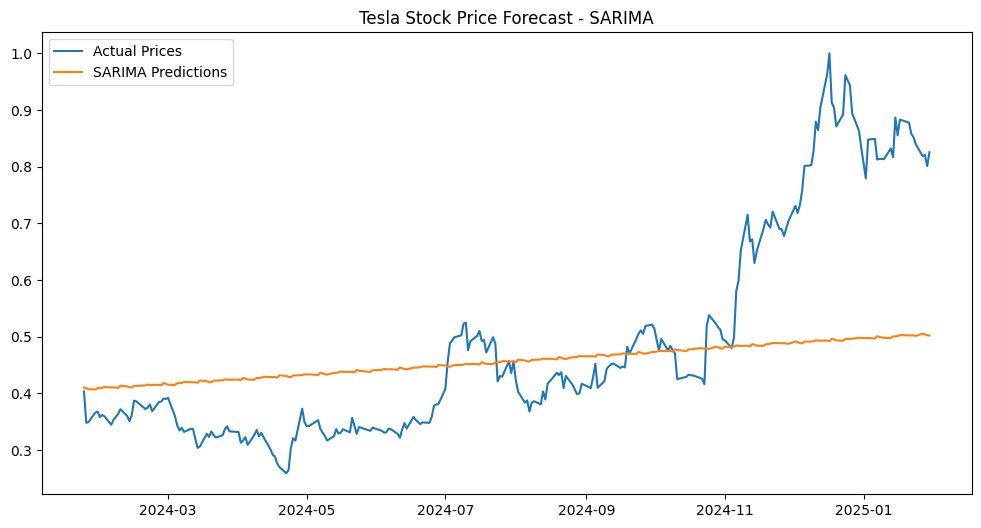

In [123]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, sarima_predictions, label="SARIMA Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - SARIMA")
plt.show()

### Train LSTM Model

In [124]:
 # LSTM Model
lstm_forecaster = LSTMForecaster(train)
lstm_forecaster.train_model()

Epoch 1/20


c:\Users\Admin\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.1080
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0113
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0069
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0068
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0106
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0070
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0076
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0068
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0054
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0056
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0054
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0054
Epoch 13/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0051
Epoch 14/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0059
Epoch 15/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0044
Epoch 16/20
31/

### Forecast Using LSTM

In [125]:
lstm_predictions = lstm_forecaster.forecast(steps=len(test))
lstm_metrics = lstm_forecaster.evaluate(test)
print("LSTM Evaluation:", lstm_metrics)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━

ValueError: Data must be 1-dimensional, got ndarray of shape (256, 256) instead

In [ ]:
lstm_forecaster.predict_future()

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

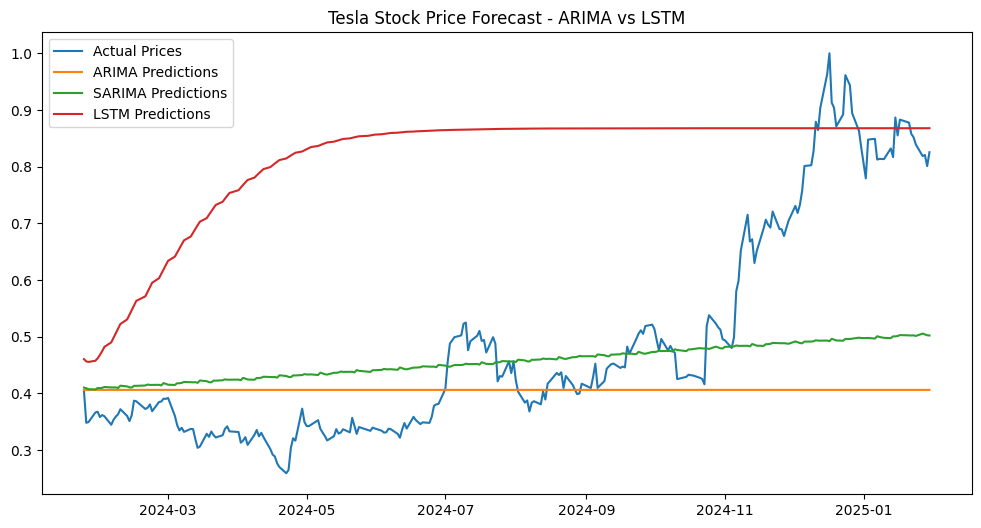

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Prices")
plt.plot(test.index, arima_predictions, label="ARIMA Predictions")
plt.plot(test.index, sarima_predictions, label="SARIMA Predictions")
plt.plot(test.index, lstm_predictions, label="LSTM Predictions")
plt.legend()
plt.title("Tesla Stock Price Forecast - ARIMA vs LSTM")
plt.show()

## Task 3: Forecast Future Market Trends

## Task 4: Optimize Portfolio Based on Forecast

### Portfolio Simulation